In [94]:
from os.path import join

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import util
import visual_words
import visual_recog
from opts import get_opts

from scipy.ndimage import gaussian_filter
import skimage.color


In [95]:
from scipy.ndimage import gaussian_filter, gaussian_laplace
import skimage.color

In [96]:
from sklearn.cluster import KMeans

In [97]:
from scipy.spatial import distance #1.3

In [98]:
import math

In [99]:
import multiprocessing

In [100]:
import cv2

In [101]:
from skimage.transform import resize

In [102]:
def extract_filter_responses(filter_scales, img):
    """
    Extracts the filter responses for the given image.

    [input]
    * opts    : options
    * img    : numpy.ndarray of shape (H,W) or (H,W,3)
    [output]
    * filter_responses: numpy.ndarray of shape (H,W,3F)
    """

#     filter_scales = opts.filter_scales

    filter_scales = filter_scales

    # ----- TODO -----
    if img.ndim == 2:     #Gray image
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    
    img = skimage.color.rgb2lab(img)
    img_min = img.min(axis=(0, 1), keepdims=True)
    img_max = img.max(axis=(0, 1), keepdims=True)
    img = (img - img_min) / (img_max - img_min)

    n_scale = len(filter_scales)
    H = img.shape[0]
    W = img.shape[1]
    filter_responses = np.empty([H, W, 3*4*n_scale], dtype = img.dtype)

    for j in range(n_scale):   #F = n_scale * 4
        for k in range(3):
            filter_responses[:, :, 4*j * 3 + k] = gaussian_filter(img[:,:,k], sigma=filter_scales[j])
        for k in range(3):
            filter_responses[:, :, (4*j+1) * 3 + k] = gaussian_laplace(img[:,:,k], sigma=filter_scales[j])
        for k in range(3):
            filter_responses[:, :, (4*j+2) * 3 + k] = gaussian_filter(img[:,:,k], sigma=filter_scales[j], order = (0, 1))
        for k in range(3):
            filter_responses[:, :, (4*j+3) * 3 + k] = gaussian_filter(img[:,:,k], sigma=filter_scales[j], order = (1, 0))
    
    return filter_responses


In [103]:
def compute_dictionary_one_image(filter_responses, alpha):
    """
    Extracts a random subset of filter responses of an image and save it to disk
    This is a worker function called by compute_dictionary

    Your are free to make your own interface based on how you implement compute_dictionary
    """

    # ----- TODO -----
    filter_responses_sampled = filter_responses.reshape(-1, filter_responses.shape[2])
    filter_responses_sampled = filter_responses_sampled[np.random.randint(filter_responses_sampled.shape[0], size=alpha), :]

    return filter_responses_sampled
#     pass


In [104]:
def compute_dictionary(opts = "Input in main.py", n_worker=1): 

    """
    Creates the dictionary of visual words by clustering using k-means.

    [input]
    * opts         : options
    * n_worker     : number of workers to process in parallel

    [saved]
    * dictionary : numpy.ndarray of shape (K,3F)
    """

    # data_dir = opts.data_dir
    # feat_dir = opts.feat_dir
    # out_dir = opts.out_dir
    # K = opts.K
    # alpha = opts.alpha
    # filter_scales = opt.filter_scales
    
    filter_scales = [1, 2, 4, 8, 8*math.sqrt(2)] #should be opt.~
    data_dir = '../data'
    feat_dir = '../feat'
    out_dir = '.'
    K = 10
    alpha = 25

    train_files = open(join(data_dir, "train_files.txt")).read().splitlines() #image list
    # ----- TODO -----

    #Load a image
    # filter_responses_sampled_all = np.empty([1, 3*4*n_scale], dtype = img.dtype)
    filter_responses_sampled_all = []

    for i in range(len(train_files)):
#         print(i)
        img_file = train_files[i]
        img_path = join(data_dir, img_file)
        # img = Image.open(img_path)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img).astype(np.float32) / 255
        # filter_responses = visual_words.extract_filter_responses(opts, img)
        
        #My idea for squaring every image into the same size(512, 512)
        smaller_side = min(img.shape[0:2])
        bigger_side = max(img.shape[0:2])
        side_indx = img.shape.index(smaller_side)

        if smaller_side == bigger_side:
            img_crop = img
        else:
            if side_indx == 0:
                img_crop = img[:,(bigger_side-smaller_side)//2:-(bigger_side-smaller_side)//2]
            else:
                img_crop = img[(bigger_side-smaller_side)//2:-(bigger_side-smaller_side)//2,:]

            if img_crop.ndim == 2:
                img_crop = np.repeat(img_crop[:, :, np.newaxis], 3, axis=2)
                
        img = resize(img_crop, (512, 512))
        
        filter_responses = extract_filter_responses(filter_scales, img)
        filter_responses_sampled = compute_dictionary_one_image(filter_responses, alpha)
    #     filter_responses_sampled_all = np.vstack((filter_responses_sampled_all, filter_responses_sampled))
        filter_responses_sampled_all.append(filter_responses_sampled)
        
        if i%100 == 0:
            print('Computing Dictionary: {}/{} files were done'.format(i, len(train_files)))

    filter_responses_sampled_all = np.vstack(filter_responses_sampled_all)
    
    kmeans = KMeans(n_clusters=K).fit(filter_responses_sampled_all)
    dictionary = kmeans.cluster_centers_
    np.save(join(out_dir, 'dictionary-square.npy'), dictionary)
    
    return filter_responses_sampled_all, dictionary


In [106]:
[filter_responses_sampled_all, dictionary] = compute_dictionary()
filter_responses_sampled_all.shape, dictionary.shape

Computing Dictionary: 0/1177 files were done
Computing Dictionary: 100/1177 files were done
Computing Dictionary: 200/1177 files were done
Computing Dictionary: 300/1177 files were done
Computing Dictionary: 400/1177 files were done
Computing Dictionary: 500/1177 files were done
Computing Dictionary: 600/1177 files were done
Computing Dictionary: 700/1177 files were done
Computing Dictionary: 800/1177 files were done
Computing Dictionary: 900/1177 files were done
Computing Dictionary: 1000/1177 files were done
Computing Dictionary: 1100/1177 files were done


((29425, 60), (10, 60))

# Q1.3

In [120]:
data_dir = '../data'
img_path = join(data_dir, 'kitchen/sun_aasmevtpkslccptd.jpg')
img = Image.open(img_path).convert("RGB")
img = np.array(img).astype(np.float32)/255
smaller_side = min(img.shape[0:2])
bigger_side = max(img.shape[0:2])
side_indx = img.shape.index(smaller_side)

if smaller_side == bigger_side:
    img_crop = img
else:
    if side_indx == 0:
        img_crop = img[:,(bigger_side-smaller_side)//2:-(bigger_side-smaller_side)//2]
    else:
        img_crop = img[(bigger_side-smaller_side)//2:-(bigger_side-smaller_side)//2,:]

    if img_crop.ndim == 2:
        img_crop = np.repeat(img_crop[:, :, np.newaxis], 3, axis=2)

img = resize(img_crop, (512, 512))

dictionary = np.load(join(out_dir, 'dictionary-square.npy'))
wordmap = get_visual_words(img, dictionary)

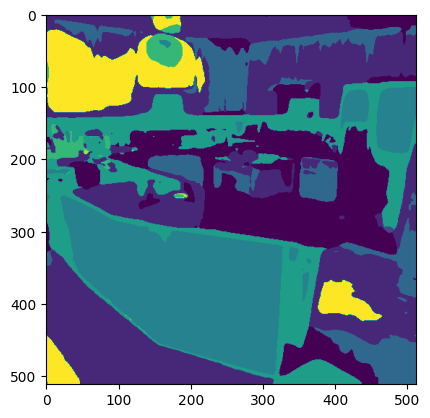

In [121]:
plt.imshow(wordmap)

In [107]:
def get_visual_words(img, dictionary, opts = "should be input in main.py"):
    """
    Compute visual words mapping for the given img using the dictionary of visual words.

    [input]
    * opts    : options
    * img    : numpy.ndarray of shape (H,W) or (H,W,3)

    [output]
    * wordmap: numpy.ndarray of shape (H,W)
    """

    # ----- TODO -----
    #filter_scales = opt.filter_scales
    filter_scales = [1, 2, 4, 8, 8*math.sqrt(2)] #should be opt.~
    filter_responses = extract_filter_responses(filter_scales, img)
    H = img.shape[0]
    W = img.shape[1]
    wordmap =  np.empty([H, W], dtype = img.dtype)
    
    for i in range(H):
        for j in range(W):
            wordmap[i,j] = distance.cdist(np.array([filter_responses[i,j,:]]), dictionary, metric='euclidean').argmin()

    return wordmap

# Q2.1

In [109]:
def get_feature_from_wordmap(wordmap, opts="input in VS"):
    """
    Compute histogram of visual words.

    [input]
    * opts      : options
    * wordmap   : numpy.ndarray of shape (H,W)

    [output]
    * hist: numpy.ndarray of shape (K)
    """

#     K = opts.K
    K = 10

    # ----- TODO -----
    hist, bins= np.histogram(wordmap, bins = range(K+1))

    return hist


# Q2.2

In [125]:
wordmap.dtype

dtype('float32')

In [124]:
test_feature = get_feature_from_wordmap_SPM(wordmap)
test_feature

array([1.109175e+04, 2.001725e+04, 2.650000e+01, 6.106250e+03,
       1.258525e+04, 9.781500e+03, 9.345000e+02, 7.750000e+00,
       2.500000e+01, 4.960250e+03, 2.013500e+03, 4.233250e+03,
       0.000000e+00, 1.791750e+03, 1.135000e+02, 3.461250e+03,
       9.345000e+02, 0.000000e+00, 2.500000e+01, 3.811250e+03,
       4.163250e+03, 6.011250e+03, 1.500000e+00, 2.215000e+03,
       1.511500e+03, 2.481500e+03, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 0.000000e+00, 5.545000e+02, 6.263250e+03,
       2.750000e+00, 3.550000e+01, 7.870500e+03, 1.198500e+03,
       0.000000e+00, 7.750000e+00, 0.000000e+00, 4.512500e+02,
       4.360500e+03, 3.509500e+03, 2.225000e+01, 2.064000e+03,
       3.089750e+03, 2.640250e+03, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 6.977500e+02, 0.000000e+00, 2.359500e+03,
       0.000000e+00, 6.680000e+02, 0.000000e+00, 0.000000e+00,
       5.050000e+01, 0.000000e+00, 0.000000e+00, 5.114000e+03,
       1.780000e+02, 2.731500e+03, 0.000000e+00, 1.6305

In [126]:
def get_feature_from_wordmap_SPM(wordmap, opts = 'should be input'):
    """
    Compute histogram of visual words using spatial pyramid matching.

    [input]
    * opts      : options
    * wordmap   : numpy.ndarray of shape (H,W)

    [output]
    * hist_all: numpy.ndarray of shape K*(4^(L+1) - 1) / 3
    """
#     K = opts.K
#     L = opts.L #For the beginning, 2 is recommended
    # ----- TODO -----
    L = 2
    K = 10
    
    smallest_cell_hight = wordmap.shape[0]//2**L 
    smallest_cell_width = wordmap.shape[1]//2**L 

    last_layer =  np.empty([2**L, 2**L, K], dtype = wordmap.dtype)
    last_layer_hist_vector =  np.empty([0], dtype = wordmap.dtype)

    hist_all =  np.empty([0], dtype = wordmap.dtype)
    #First, compute histograms for the last layer
    for i in range(last_layer.shape[0]):
        for j in range(last_layer.shape[1]):
            last_layer[i,j,:] = get_feature_from_wordmap(\
                                wordmap[smallest_cell_hight*i:smallest_cell_hight*(i+1),\
                                        smallest_cell_width*(j):smallest_cell_width*(j+1)])
            last_layer_hist_vector = np.concatenate([last_layer_hist_vector, last_layer[i,j,:]])

    if L<=1:
        last_layer_hist_vector *= 2**(-L)
    else:
        last_layer_hist_vector *= 2**(-1)

    for i in range(L):
        group = 2**(L-i) #num of the smallest cell for upper layers on 
        for m in range((last_layer.shape[0]//group)):
            for n in range((last_layer.shape[1]//group)):
                upper_cell_hist = last_layer[m*group:(m+1)*group, n*group:(n+1)*group, :].sum(axis=(0,1)) #sum of each cell
                if i<=1:
                    upper_cell_hist *= 2**(-L)
                else:
                    upper_cell_hist *= 2**(i-L-1)

                hist_all = np.concatenate([hist_all, upper_cell_hist])
#                 print(upper_cell_hist)
    hist_all = np.concatenate([hist_all, last_layer_hist_vector])
    hist_all = hist_all/np.linalg.norm(hist_all, ord=1)
    return hist_all

# Q2.3

In [127]:
def similarity_to_set(word_hist, histograms):
    """
    Compute similarity between a histogram of visual words with all training image histograms.

    [input]
    * word_hist: numpy.ndarray of shape (K)
    * histograms: numpy.ndarray of shape (N,K)

    [output]
    * sim: numpy.ndarray of shape (N)
    """

    # ----- TODO -----
    minima = np.minimum(word_hist, histograms)
    sim = np.sum(minima, axis=1)
    sim_norm = np.true_divide(np.sum(minima, axis=1), np.sum(histograms, axis=1))
    dist = 1-sim_norm

    return dist


# Q2.4

In [112]:
def get_image_feature(img_path, dictionary, opts = 'input for main.py'):
    """
    Extracts the spatial pyramid matching feature.

    [input]
    * opts      : options
    * img_path  : path of image file to read
    * dictionary: numpy.ndarray of shape (K, 3F)


    [output]
    * feature: numpy.ndarray of shape (K)
    """
    # ----- TODO -----

    img = Image.open(img_path).convert("RGB")
    img = np.array(img).astype(np.float32) / 255
    
        #My idea for squaring every image into the same size(512, 512)
    smaller_side = min(img.shape[0:2])
    bigger_side = max(img.shape[0:2])
    side_indx = img.shape.index(smaller_side)

    if smaller_side == bigger_side:
        img_crop = img
    else:
        if side_indx == 0:
            img_crop = img[:,(bigger_side-smaller_side)//2:-(bigger_side-smaller_side)//2]
        else:
            img_crop = img[(bigger_side-smaller_side)//2:-(bigger_side-smaller_side)//2,:]

        if img_crop.ndim == 2:
            img_crop = np.repeat(img_crop[:, :, np.newaxis], 3, axis=2)

    img = resize(img_crop, (512, 512))
  
    wordmap = get_visual_words(img, dictionary)
    feature = get_feature_from_wordmap_SPM(wordmap)
    
    return feature

In [114]:
def build_recognition_system(n_worker=1, opts='input for main.py'):
    """
    Creates a trained recognition system by generating training features from all training images.

    [input]
    * opts        : options
    * n_worker  : number of workers to process in parallel

    [saved]
    * features: numpy.ndarray of shape (N,M)
    * labels: numpy.ndarray of shape (N)
    * dictionary: numpy.ndarray of shape (K,3F)
    * SPM_layer_num: number of spatial pyramid layers
    """

#     data_dir = opts.data_dir
#     out_dir = opts.out_dir
#     SPM_layer_num = opts.L

    data_dir = '../data'
    out_dir = '.'
    SPM_layer_num = 2


    train_files = open(join(data_dir, "train_files.txt")).read().splitlines()
    train_labels = np.loadtxt(join(data_dir, "train_labels.txt"), np.int32)
    dictionary = np.load(join(out_dir, "dictionary-square.npy"))

    # ----- TODO -----
    wordmap_list = []
    features = []
    for i in range(len(train_files)):
        img_file = train_files[i]
        img_path = join(data_dir, img_file)
        # img = Image.open(img_path)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img).astype(np.float32) / 255
        
                #My idea for squaring every image into the same size(512, 512)
        smaller_side = min(img.shape[0:2])
        bigger_side = max(img.shape[0:2])
        side_indx = img.shape.index(smaller_side)

        if smaller_side == bigger_side:
            img_crop = img
        else:
            if side_indx == 0:
                img_crop = img[:,(bigger_side-smaller_side)//2:-(bigger_side-smaller_side)//2]
            else:
                img_crop = img[(bigger_side-smaller_side)//2:-(bigger_side-smaller_side)//2,:]

            if img_crop.ndim == 2:
                img_crop = np.repeat(img_crop[:, :, np.newaxis], 3, axis=2)

        img = resize(img_crop, (512, 512))

        feature = get_image_feature(img_path, dictionary) #Extracts the spatial pyramid matching feature.
        features.append(feature)
        if i%100 == 0:
            print('Building system: {}/{} files were done'.format(i, len(train_files)))
    features = np.vstack(features)

    np.savez_compressed(join(out_dir, 'trained_system-square.npz'),
        features=features,
        labels=train_labels,
        dictionary=dictionary,
        SPM_layer_num=SPM_layer_num,
    )
    
    return features

In [115]:
features_test = build_recognition_system()

Building system: 0/1177 files were done
Building system: 100/1177 files were done
Building system: 200/1177 files were done
Building system: 300/1177 files were done
Building system: 400/1177 files were done
Building system: 500/1177 files were done
Building system: 600/1177 files were done
Building system: 700/1177 files were done
Building system: 800/1177 files were done
Building system: 900/1177 files were done
Building system: 1000/1177 files were done
Building system: 1100/1177 files were done


In [129]:
sum(features_test[200])

1.0

# Q2.5

In [132]:
trained_system = np.load(join(out_dir, "trained_system-square.npz"))
dictionary = trained_system["dictionary"]

# using the stored options in the trained system instead of opts.py
#     test_opts = copy(opts)
#     test_opts.K = dictionary.shape[0]
#     test_opts.L = trained_system["SPM_layer_num"]

K = dictionary.shape[0]
L = trained_system["SPM_layer_num"]

test_files = open(join(data_dir, "test_files.txt")).read().splitlines()
test_labels = np.loadtxt(join(data_dir, "test_labels.txt"), np.int32)
train_labels = trained_system["labels"]
features = trained_system["features"]


conf2 =  np.zeros([8, 8])

for i in range(len(test_files)):
# for i in range(100):
    img_file = test_files[i]
    img_path = join(data_dir, img_file)
    # img = Image.open(img_path)
    img = Image.open(img_path).convert("RGB")
    img = np.array(img).astype(np.float32) / 255
    feature_test = get_image_feature(img_path, dictionary)
    dist_list = similarity_to_set(feature_test, features)
    pred = train_labels[dist_list.argmin()]
    conf2[test_labels[i], pred] +=1
    if i%100 == 0:
        print('Inference: {}/{} files were done'.format(i, len(test_files)))

# accuracy = np.trace(conf)/conf.sum()

Inference: 0/400 files were done
Inference: 100/400 files were done
Inference: 200/400 files were done
Inference: 300/400 files were done


In [134]:
conf2

array([[21.,  4.,  4.,  6.,  3.,  3.,  1.,  8.],
       [ 0., 33.,  5.,  4.,  3.,  0.,  1.,  4.],
       [ 1.,  6., 24.,  1.,  0.,  5.,  2., 11.],
       [ 3.,  4.,  2., 21., 12.,  4.,  3.,  1.],
       [ 2.,  2.,  2., 12., 23.,  5.,  1.,  3.],
       [ 3.,  0.,  5.,  1.,  5., 27.,  2.,  7.],
       [ 1.,  0.,  0.,  1.,  5.,  6., 30.,  7.],
       [ 3.,  3.,  9.,  1.,  5.,  4.,  4., 21.]])

In [136]:
accuracy = np.trace(conf2)/conf2.sum()
accuracy

0.5

In [140]:
accuracy = np.trace(conf)/conf.sum()
accuracy

0.4975

In [139]:
conf = np.array([[24.,  3.,  5.,  5.,  5.,  0.,  3.,  5.],
               [ 1., 31.,  4.,  5.,  2.,  1.,  1.,  5.],
               [ 0.,  7., 19.,  2.,  4.,  4.,  2., 12.],
               [ 6.,  3.,  1., 19., 10.,  4.,  5.,  2.],
               [ 4.,  1.,  3.,  5., 31.,  4.,  1.,  1.],
               [ 3.,  0.,  2.,  3.,  3., 26.,  5.,  8.],
               [ 1.,  1.,  4.,  0.,  8.,  5., 27.,  4.],
               [ 4.,  6., 11.,  1.,  2.,  3.,  1., 22.]])

In [1462]:
conf

array([[24.,  3.,  5.,  5.,  5.,  0.,  3.,  5.],
       [ 1., 31.,  4.,  5.,  2.,  1.,  1.,  5.],
       [ 0.,  7., 19.,  2.,  4.,  4.,  2., 12.],
       [ 6.,  3.,  1., 19., 10.,  4.,  5.,  2.],
       [ 4.,  1.,  3.,  5., 31.,  4.,  1.,  1.],
       [ 3.,  0.,  2.,  3.,  3., 26.,  5.,  8.],
       [ 1.,  1.,  4.,  0.,  8.,  5., 27.,  4.],
       [ 4.,  6., 11.,  1.,  2.,  3.,  1., 22.]])

In [1489]:
i = 121
img_file = test_files[i]
img_path = join(data_dir, img_file)
img = Image.open(img_path).convert("RGB")
img = np.array(img).astype(np.float32)/255
wordmap = get_visual_words(img, dictionary)
feature_test = get_image_feature(img_path, dictionary)
dist_list = similarity_to_set(feature_test, features)
pred = train_labels[dist_list.argmin()]
# util.visualize_wordmap(wordmap)

In [1490]:
print(test_labels[i], pred)

2 7


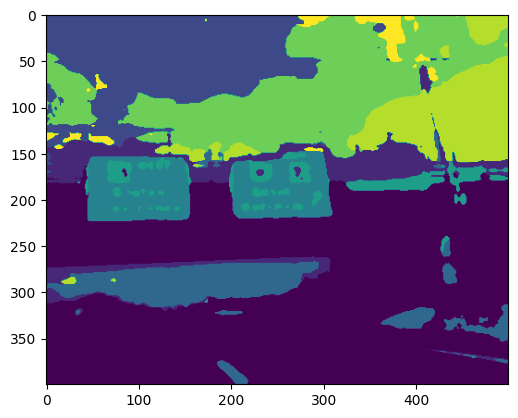

In [1491]:
plt.imshow(wordmap)

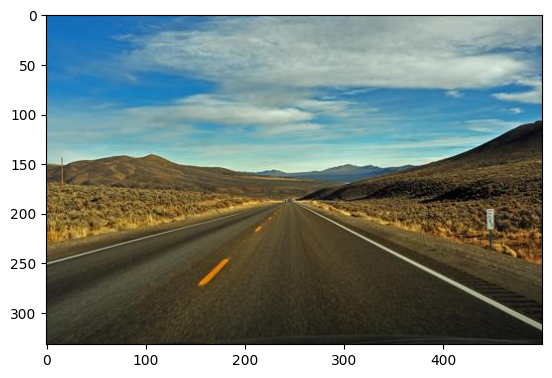

In [1441]:
plt.imshow(img)

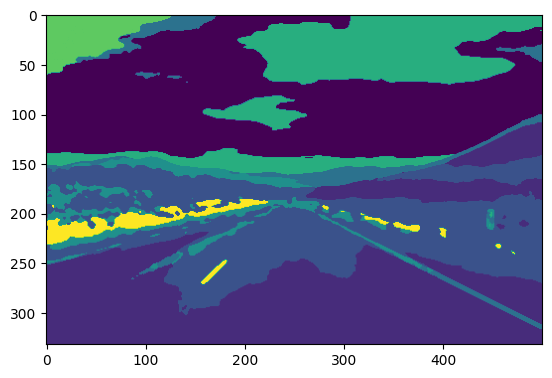

In [1445]:
plt.imshow(wordmap)

In [1483]:
i = 373
img_file = test_files[i]
img_path = join(data_dir, img_file)
img = Image.open(img_path).convert("RGB")
img = np.array(img).astype(np.float32)/255
wordmap = get_visual_words(img, dictionary)
feature_test = get_image_feature(img_path, dictionary)
dist_list = similarity_to_set(feature_test, features)
pred = train_labels[dist_list.argmin()]
# util.visualize_wordmap(wordmap)

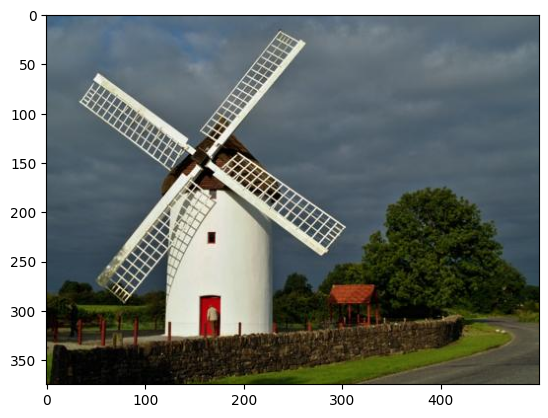

In [1484]:
plt.imshow(img)

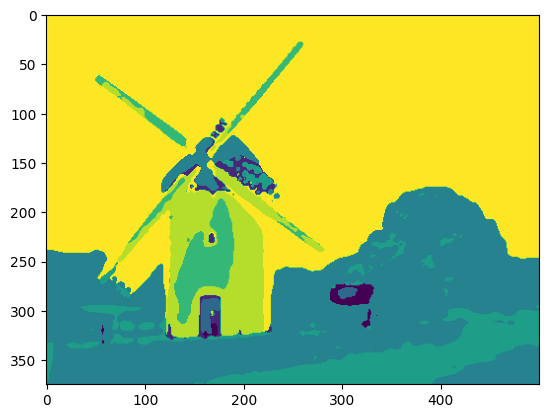

In [1485]:
plt.imshow(wordmap)

In [ ]:
def evaluate_recognition_system(n_worker=1, opts='input for main.py'):
    """
    Evaluates the recognition system for all test images and returns the confusion matrix.

    [input]
    * opts        : options
    * n_worker  : number of workers to process in parallel

    [output]
    * conf: numpy.ndarray of shape (8,8)
    * accuracy: accuracy of the evaluated system
    """

    data_dir = opts.data_dir
    out_dir = opts.out_dir

    trained_system = np.load(join(out_dir, "trained_system-square.npz"))
    dictionary = trained_system["dictionary"]

    # using the stored options in the trained system instead of opts.py
#     test_opts = copy(opts)
#     test_opts.K = dictionary.shape[0]
#     test_opts.L = trained_system["SPM_layer_num"]

    K = dictionary.shape[0]
    L = trained_system["SPM_layer_num"]
    
    test_files = open(join(data_dir, "test_files.txt")).read().splitlines()
    test_labels = np.loadtxt(join(data_dir, "test_labels.txt"), np.int32)
    train_labels = trained_system["labels"]
    features = trained_system["features"]

    # ----- TODO -----
    conf =  np.zeros([8, 8])

    for i in range(len(test_files)):
    # for i in range(100):
        img_file = test_files[i]
        img_path = join(data_dir, img_file)
        # img = Image.open(img_path)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img).astype(np.float32) / 255
                #My idea for squaring every image into the same size(512, 512)
        smaller_side = min(img.shape[0:2])
        bigger_side = max(img.shape[0:2])
        side_indx = img.shape.index(smaller_side)

        if smaller_side == bigger_side:
            img_crop = img
        else:
            if side_indx == 0:
                img_crop = img[:,(bigger_side-smaller_side)//2:-(bigger_side-smaller_side)//2]
            else:
                img_crop = img[(bigger_side-smaller_side)//2:-(bigger_side-smaller_side)//2,:]

            if img_crop.ndim == 2:
                img_crop = np.repeat(img_crop[:, :, np.newaxis], 3, axis=2)

        img = resize(img_crop, (512, 512))

        feature_test = get_image_feature(img_path, dictionary)
        dist_list = similarity_to_set(feature_test, features)
        pred = train_labels[dist_list.argmin()]
        conf[test_labels[i], pred] +=1
        if i%100 == 0:
            print('{}/{} files were done'.format(i, len(test_files)))

    accuracy = np.trace(conf)/conf.sum()
    return conf, accuracy

In [1450]:
8*2*2**(1/2)

22.627416997969522

In [1449]:
math.sqrt(2)

1.4142135623730951

In [1451]:
import os
print(os.cpu_count())

8
